<a href="https://colab.research.google.com/github/stlmx/stlmx/blob/master/unet_by_sj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from IPython.display import Image # to display images

print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [8]:
cd drive/MyDrive/Pytorch┤·┬ы/

/content/drive/MyDrive/Pytorch┤·┬ы


In [9]:
# Model config ======
RUN_NAME        = 'unetv1_pothole'
N_CLASSES       = 1
EPOCHS          = 50
LEARNING_RATE   = 0.002
START_FRAME     = 16
DROP_RATE       = 0.5

# Data config =======
DATA_PATH       = './input/'
IMAGE_PATH      = 'train/images/'
MASK_PATH       = 'train/masks/'
TEST_IMAGE_PATH = 'test/images/'
TEST_MASK_PATH  = 'test/masks/'
IMAGE_TYPE      = '.jpg'
MASK_TYPE       = '.png'
LOG_PATH        = './runs'
SAVE_PATH       = './'

REAL_HEIGHT     = 200
REAL_WIDTH      = 240
IMG_HEIGHT      = 256 #720   
IMG_WIDTH       = 512 #1280  
RANDOM_SEED     = 42
VALID_RATIO     = 0.2
BATCH_SIZE      = 4 #16
NUM_WORKERS     = 1
CLASSES         = {1:'opject'}

In [10]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, dataloader, random_split

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import copy

In [11]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(LOG_PATH)

In [12]:
class PotholeDataset(Dataset):
    """Pothole Identification dataset."""
    
    def __init__(self, root_dir=DATA_PATH, transform=None):
        """
        Args:
            root_path (string): Directory with all the images.
            transformer (function): whether to apply the data augmentation scheme
                mentioned in the paper. Only applied on the train split.
        """

        # load dataset from root dir
        self.root_dir   = root_dir
        listname =[]
        for imgfile in os.listdir(DATA_PATH + IMAGE_PATH):
            if os.path.splitext(imgfile)[1] == IMAGE_TYPE:
                filename = os.path.splitext(imgfile)[0]
                listname.append(filename)
        self.ids        = listname #train_df.index

        if transform is None:
            self.transfrom = transforms.Compose([transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=transforms.InterpolationMode.NEAREST),
                                                 #transforms.Grayscale(),
                                                 transforms.ToTensor(),])

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        id    = self.ids[index]

        # file should be unzipped
        image = Image.open(self.root_dir+IMAGE_PATH+id + IMAGE_TYPE)
        mask  = Image.open(self.root_dir+MASK_PATH+id + MASK_TYPE)
    
        image = self.transfrom(image)
        mask  = self.transfrom(mask)

        return image, mask

In [13]:
def get_dataloader(dataset, 
                    batch_size=BATCH_SIZE, random_seed=RANDOM_SEED, 
                    valid_ratio=VALID_RATIO, shuffle=True, num_workers=NUM_WORKERS):
    """
    Params:
    -------
    - dataset: the dataset.
    - batch_size: how many samples per batch to load.
    - random_seed: fix seed for reproducibility.
    - valid_ratio: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - num_workers: number of subprocesses to use when loading the dataset.
    """

    error_msg = "[!] valid_ratio should be in the range [0, 1]."
    assert ((valid_ratio >= 0) and (valid_ratio <= 1)), error_msg

    # split the dataset
    n = len(dataset)
    n_valid = int(valid_ratio*n)
    n_train = n - n_valid

    # init random seed
    torch.manual_seed(random_seed)

    train_dataset, valid_dataset = random_split(dataset, (n_train, n_valid))

    train_loader = DataLoader(train_dataset, batch_size, shuffle=shuffle, num_workers=num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, valid_loader

In [14]:
dataset = PotholeDataset(DATA_PATH)
trainloader, validloader = get_dataloader(dataset=dataset, valid_ratio=0.10)

In [15]:
def show_dataset(dataset, n_sample=4):
    """Visualize dataset with n_sample"""
    plt.figure(figsize=(30, 15))

    # show image
    for i in range(n_sample):
        image, mask = dataset[i]
        image = transforms.ToPILImage()(image)
        mask = transforms.ToPILImage()(mask)
        print(i, image.size, mask.size)


        plt.tight_layout()
        ax = plt.subplot(n_sample, 1, i + 1)
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')

        plt.imshow(image, cmap="Greys")
        plt.imshow(mask, alpha=0.3, cmap="OrRd")

        if i == n_sample-1:
            plt.show()
            break

0 (512, 256) (512, 256)
1 (512, 256) (512, 256)
2 (512, 256) (512, 256)
3 (512, 256) (512, 256)


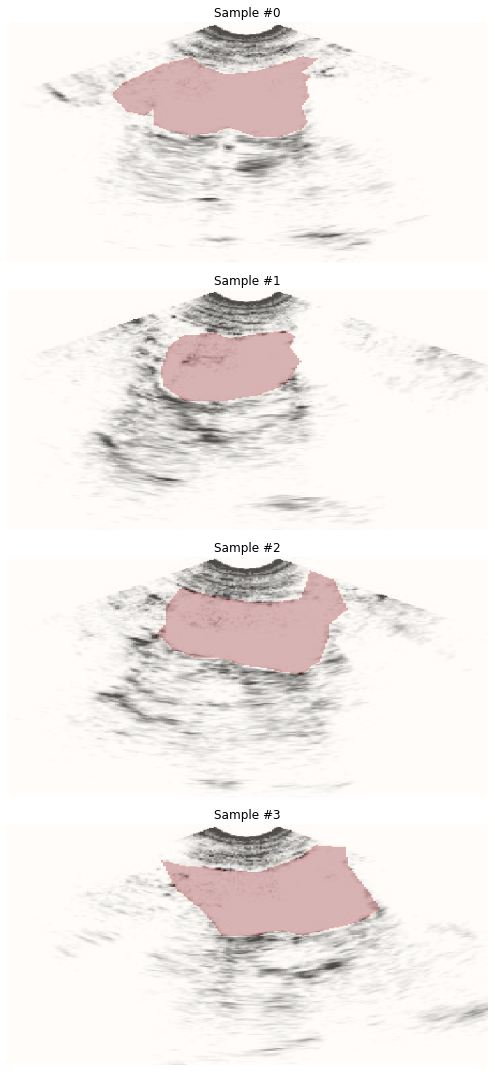

In [16]:
show_dataset(dataset)

In [17]:
class BatchActivate(nn.Module):
    def __init__(self, num_features):
        super(BatchActivate, self).__init__()
        self.norm = nn.BatchNorm2d(num_features)

    def forward(self, x):
        return F.relu(self.norm(x))

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=3, padding=1, stride=1, activation=True):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                            kernel_size=kernel, stride=stride, padding=padding)
        self.batchnorm  = BatchActivate(out_channels)
        self.activation = activation

    def forward(self, x):
        x = self.conv(x)
        if self.activation:
            x = self.batchnorm(x)
        return x

class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=3, padding=1, stride=1):
        super(DoubleConvBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, kernel, padding, stride)
        self.conv2 = ConvBlock(out_channels, out_channels, kernel, padding, stride)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, batch_activation=False):
        super(ResidualBlock, self).__init__()
        self.batch_activation = batch_activation
        self.norm  = nn.BatchNorm2d(num_features=in_channels)
        self.conv1 = ConvBlock(in_channels, in_channels, kernel=3, stride=1, padding=1)
        self.conv2 = ConvBlock(in_channels, in_channels, kernel=3, stride=1, padding=1, activation=False)

    def forward(self, x):
        residual = x
        x = self.norm(x)
        x = self.conv1(x)
        x = self.conv2(x)

        x += residual
        # x = x.view(x.size(0),-1)
        
        if self.batch_activation:
            x = self.norm(x)
        
        return x

In [18]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, n_classes=N_CLASSES, dropout = 0.2, start_fm=START_FRAME):
        super(UNet, self).__init__()
        # Input 1x128x128
        
        #Dropout
        self.drop = dropout

        # Maxpool 
        self.pool = nn.MaxPool2d((2,2))

        # Transpose conv
        self.deconv_4  = nn.ConvTranspose2d(start_fm*16, start_fm*8, 2, 2)
        self.deconv_3  = nn.ConvTranspose2d(start_fm*8, start_fm*4, 2, 2)
        self.deconv_2  = nn.ConvTranspose2d(start_fm*4, start_fm*2, 2, 2)
        self.deconv_1  = nn.ConvTranspose2d(start_fm*2, start_fm, 2, 2)
        
        # Encoder 
        self.encoder_1 = DoubleConvBlock(in_channels, start_fm, kernel=3)
        self.encoder_2 = DoubleConvBlock(start_fm, start_fm*2, kernel=3)
        self.encoder_3 = DoubleConvBlock(start_fm*2, start_fm*4, kernel=3)
        self.encoder_4 = DoubleConvBlock(start_fm*4, start_fm*8, kernel=3)

        # Middle
        self.middle = DoubleConvBlock(start_fm*8, start_fm*16)
        
        # Decoder
        self.decoder_4 = DoubleConvBlock(start_fm*16, start_fm*8)
        self.decoder_3 = DoubleConvBlock(start_fm*8, start_fm*4)
        self.decoder_2 = DoubleConvBlock(start_fm*4, start_fm*2)
        self.decoder_1 = DoubleConvBlock(start_fm*2, start_fm)

        self.conv_last = nn.Conv2d(start_fm, n_classes, 1)

    def forward(self, x):
        # Encoder
        conv1 = self.encoder_1(x)
        x     = self.pool(conv1)
        x = nn.Dropout2d(self.drop)(x)

        conv2 = self.encoder_2(x)
        x     = self.pool(conv2)
        x = nn.Dropout2d(self.drop)(x)

        conv3 = self.encoder_3(x)
        x     = self.pool(conv3)
        x = nn.Dropout2d(self.drop)(x)

        conv4 = self.encoder_4(x)
        x     = self.pool(conv4)
        x = nn.Dropout2d(self.drop)(x)

        # Middle
        x     = self.middle(x)

        # Decoder
        x     = self.deconv_4(x)
        x     = torch.cat([conv4, x], dim=1)
        x = nn.Dropout2d(self.drop)(x)
        x     = self.decoder_4(x)

        x     = self.deconv_3(x)
        x     = torch.cat([conv3, x], dim=1)
        x     = nn.Dropout2d(self.drop)(x)
        x     = self.decoder_3(x)

        x     = self.deconv_2(x)
        x     = torch.cat([conv2, x], dim=1)
        x     = nn.Dropout2d(self.drop)(x)
        x     = self.decoder_2(x)

        x     = self.deconv_1(x)
        x     = torch.cat([conv1, x], dim=1)
        x     = nn.Dropout2d(self.drop)(x)
        x     = self.decoder_1(x)
        
        out   = self.conv_last(x)
        return out

In [19]:
class UNet_ResNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=N_CLASSES, dropout=0.1, start_fm=START_FRAME):
        super(UNet_ResNet, self).__init__()
        #Dropout
        self.drop = dropout
        #Pooling
        self.pool = nn.MaxPool2d((2,2))

        # Encoder 
        self.encoder_1 = nn.Sequential(
            nn.Conv2d(in_channels, start_fm, 3, padding=(1,1)),
            ResidualBlock(start_fm),
            ResidualBlock(start_fm, batch_activation=True),
#             nn.MaxPool2d((2,2)),
#             nn.Dropout2d(dropout//2),
        )

        self.encoder_2 = nn.Sequential(
            nn.Conv2d(start_fm, start_fm*2, 3, padding=(1,1)),
            ResidualBlock(start_fm*2),
            ResidualBlock(start_fm*2, batch_activation=True),
#             nn.MaxPool2d((2,2)),
#             nn.Dropout2d(dropout),
        )

        self.encoder_3 = nn.Sequential(
            nn.Conv2d(start_fm*2, start_fm*4, 3, padding=(1,1)),
            ResidualBlock(start_fm*4),
            ResidualBlock(start_fm*4, batch_activation=True),
#             nn.MaxPool2d((2,2)),
#             nn.Dropout2d(dropout),
        )
        
        self.encoder_4 = nn.Sequential(
            nn.Conv2d(start_fm*4, start_fm*8, 3, padding=(1,1)),
            ResidualBlock(start_fm*8),
            ResidualBlock(start_fm*8, batch_activation=True),
#             nn.MaxPool2d((2,2)),
#             nn.Dropout2d(dropout),
        )

        self.middle = nn.Sequential(
            nn.Conv2d(start_fm*8, start_fm*16, 3, padding=3//2),
            ResidualBlock(start_fm*16),
            ResidualBlock(start_fm*16, batch_activation=True),
#             nn.MaxPool2d((2,2))
        )
        
        # Transpose conv
        self.deconv_4  = nn.ConvTranspose2d(start_fm*16, start_fm*8, 2, 2)
        self.deconv_3  = nn.ConvTranspose2d(start_fm*8, start_fm*4, 2, 2)
        self.deconv_2  = nn.ConvTranspose2d(start_fm*4, start_fm*2, 2, 2)
        self.deconv_1  = nn.ConvTranspose2d(start_fm*2, start_fm, 2, 2)

        # Decoder 
        self.decoder_4 = nn.Sequential(
            nn.Dropout2d(dropout),
            nn.Conv2d(start_fm*16, start_fm*8, 3, padding=(1,1)),
            ResidualBlock(start_fm*8),
            ResidualBlock(start_fm*8, batch_activation=True),
        )

        self.decoder_3 = nn.Sequential(
            nn.Dropout2d(dropout),
            nn.Conv2d(start_fm*8, start_fm*4, 3, padding=(1,1)),
            ResidualBlock(start_fm*4),
            ResidualBlock(start_fm*4, batch_activation=True),
        )

        self.decoder_2 = nn.Sequential(
            nn.Dropout2d(dropout),
            nn.Conv2d(start_fm*4, start_fm*2, 3, padding=(1,1)),
            ResidualBlock(start_fm*2),
            ResidualBlock(start_fm*2, batch_activation=True),
        )

        self.decoder_1 = nn.Sequential(
            nn.Dropout2d(dropout),
            nn.Conv2d(start_fm*2, start_fm, 3, padding=(1,1)),
            ResidualBlock(start_fm),
            ResidualBlock(start_fm, batch_activation=True),
        )
            
        self.conv_last = nn.Conv2d(start_fm, n_classes, 1)

    def forward(self, x):
        # Encoder
        
        conv1 = self.encoder_1(x) #128
        x = self.pool(conv1) # 64
        x = nn.Dropout2d(self.drop)(x)

        conv2 = self.encoder_2(x) #64
        x = self.pool(conv2) # 32
        x = nn.Dropout2d(self.drop)(x)

        conv3 = self.encoder_3(x) #32
        x = self.pool(conv3) #16
        x = nn.Dropout2d(self.drop)(x)

        conv4 = self.encoder_4(x) #16
        x = self.pool(conv4) # 8
        x = nn.Dropout2d(self.drop)(x)


        # Middle
        x     = self.middle(x) # 8
        
        # Decoder
        x     = self.deconv_4(x) #16
        x     = torch.cat([conv4, x], dim=1) #16
        x     = self.decoder_4(x)
        

        x     = self.deconv_3(x) #32
        x     = torch.cat([conv3, x], dim=1)
        x     = self.decoder_3(x)


        x     = self.deconv_2(x) #64
        x     = torch.cat([conv2, x], dim=1)
        x     = self.decoder_2(x)


        x     = self.deconv_1(x) # 128
        x     = torch.cat([conv1, x], dim=1)
        x     = self.decoder_1(x)

        out   = (self.conv_last(x)) # 128
        return out

In [20]:
def labels():
  l = {}
  for i, label in enumerate(CLASSES):
    l[i] = label
  return l

def tensor2np(tensor):
    tensor = tensor.squeeze().cpu()
    return tensor.detach().numpy()

def normtensor(tensor):
    tensor = torch.where(tensor<0., torch.zeros(1).cuda(), torch.ones(1).cuda())
    return tensor
  
def count_params(model):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    return pytorch_total_params

In [21]:
def cal_iou(outputs, labels, SMOOTH=1e-6):
    with torch.no_grad():
        outputs = outputs.squeeze(1).bool()  # BATCH x 1 x H x W => BATCH x H x W
        labels = labels.squeeze(1).bool()
        
        intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
        union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
        
        iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
   
    return iou


def get_iou_score(outputs, labels):
    A = labels.squeeze(1).bool()
    pred = torch.where(outputs<0., torch.zeros(1).cuda(), torch.ones(1).cuda())
    B = pred.squeeze(1).bool()
    intersection = (A & B).float().sum((1,2))
    union = (A| B).float().sum((1, 2)) 
    iou = (intersection + 1e-6) / (union + 1e-6)  
    
    return iou.cpu().detach().numpy()

In [22]:
def train(model, device, trainloader, optimizer, loss_function, epoch):
    model.train()
    running_loss = 0
    mask_list, iou = [], []
    for i, (input, mask) in enumerate(trainloader):
        # load data into cuda
        input, mask = input.to(device), mask.to(device)

        # forward
        predict = model(input)
        loss = loss_function(predict, mask)

        # metric
        iou.append(get_iou_score(predict, mask).mean())
        running_loss += (loss.item())
        
        # zero the gradient + backprpagation + step
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        # log the first image of the batch
        if ((i + 1) % 10) == 0:
            pred = normtensor(predict[0])
            img, pred, mak = tensor2np(input[0]), tensor2np(pred), tensor2np(mask[0])
            
    mean_iou = np.mean(iou)
    total_loss = running_loss/len(trainloader)
    writer.add_scalar('training loss',
                        total_loss,
                        epoch)

    return total_loss, mean_iou

In [23]:
def test(model, device, testloader, loss_function, best_iou, epoch):
    model.eval()
    running_loss = 0
    mask_list, iou  = [], []
    with torch.no_grad():
        for i, (input, mask) in enumerate(testloader):
            input, mask = input.to(device), mask.to(device)

            predict = model(input)
            loss = loss_function(predict, mask)

            running_loss += loss.item()
            iou.append(get_iou_score(predict, mask).mean())

            # log the first image of the batch
            if ((i + 1) % 1) == 0:
                pred = normtensor(predict[0])
                img, pred, mak = tensor2np(input[0]), tensor2np(pred), tensor2np(mask[0])

    test_loss = running_loss/len(testloader)
    mean_iou = np.mean(iou)
    
    writer.add_scalar('val loss',
                     test_loss,
                     epoch)
    
    if mean_iou>best_iou:
    
        try:
            torch.save(model.state_dict(), SAVE_PATH+RUN_NAME+'.pth')
        except:
            print('Can export weights')

    return test_loss, mean_iou

In [24]:
def model_pipeline(prev_model = None):
    best_model = None

    # make the model, data, and optimization
    model, criterion, optimizer = make_model(prev_model)

    best_iou = -1
    for epoch in range(EPOCHS):

        t0 = time.time()
        train_loss, train_iou = train(model, device, trainloader, optimizer, criterion, epoch)
        t1 = time.time()

        print(f'Epoch: {epoch} | Train loss: {train_loss:.3f} | Train IoU: {train_iou:.3f} | Time: {(t1-t0):.1f}s')

        test_loss, test_iou = test(model, device, validloader, criterion, best_iou, epoch)
        print(f'Epoch: {epoch} | Valid loss: {test_loss:.3f} | Valid IoU: {test_iou:.3f} | Time: {(t1-t0):.1f}s')

        
        if best_iou < test_iou:
            best_iou = test_iou
            best_model = copy.deepcopy(model)
        
    return best_model

In [25]:
def make_model(prev_model = None):
    # Make the model
    if prev_model == None:
        model = UNet_ResNet().to(device)
    else:
        model = prev_model

    print('Number of parameter:', count_params(model))

    # Make the loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer   = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    return model, criterion, optimizer

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
model = model_pipeline(prev_model=None)
# tensorboard --logdir=runs

Number of parameter: 4896369
Epoch: 0 | Train loss: 0.641 | Train IoU: 0.202 | Time: 8.2s
Epoch: 0 | Valid loss: 37.440 | Valid IoU: 0.093 | Time: 8.2s
Epoch: 1 | Train loss: 0.523 | Train IoU: 0.491 | Time: 7.0s
Epoch: 1 | Valid loss: 1619.407 | Valid IoU: 0.091 | Time: 7.0s
Epoch: 2 | Train loss: 0.447 | Train IoU: 0.620 | Time: 7.0s
Epoch: 2 | Valid loss: 426.231 | Valid IoU: 0.101 | Time: 7.0s
Epoch: 3 | Train loss: 0.399 | Train IoU: 0.683 | Time: 7.0s
Epoch: 3 | Valid loss: 68.943 | Valid IoU: 0.154 | Time: 7.0s
Epoch: 4 | Train loss: 0.366 | Train IoU: 0.688 | Time: 7.0s
Epoch: 4 | Valid loss: 7.992 | Valid IoU: 0.319 | Time: 7.0s
Epoch: 5 | Train loss: 0.331 | Train IoU: 0.767 | Time: 7.0s
Epoch: 5 | Valid loss: 3.420 | Valid IoU: 0.206 | Time: 7.0s
Epoch: 6 | Train loss: 0.318 | Train IoU: 0.779 | Time: 7.0s
Epoch: 6 | Valid loss: 1.450 | Valid IoU: 0.438 | Time: 7.0s
Epoch: 7 | Train loss: 0.304 | Train IoU: 0.748 | Time: 7.0s
Epoch: 7 | Valid loss: 0.604 | Valid IoU: 0.571 |

In [28]:
writer.close()

In [29]:
class Test_PotholeDataset(Dataset):
    """Pothole Salt Identification dataset."""
    
    def __init__(self, root_dir=DATA_PATH, transform=None):
        """
        Args:
            root_path (string): Directory with all the images.
            transformer (function): whether to apply the data augmentation scheme
                mentioned in the paper. Only applied on the train split.
        """

        # load dataset from root dir
        self.root_dir   = root_dir
        listname =[]
        for imgfile in os.listdir(DATA_PATH + TEST_MASK_PATH):
            if os.path.splitext(imgfile)[1] == MASK_TYPE:
                filename = os.path.splitext(imgfile)[0]
                listname.append(filename)
        self.ids        = listname #train_df.index
        
        if transform is None:
            self.transfrom = transforms.Compose(
                [transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=transforms.InterpolationMode.NEAREST),
                                                #[transforms.Grayscale(),
                                                transforms.ToTensor(),])

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        id    = self.ids[index]

        # file should be unzipped
        image = Image.open(self.root_dir+TEST_IMAGE_PATH+id+IMAGE_TYPE)
        image = self.transfrom(image)

        return image

In [30]:
def show_test_dataset(dataset, n_sample=2):
    """Visualize dataset with n_sample"""
    plt.figure(figsize=(30, 15))

    # show image
    for i in range(n_sample):
        image = dataset[i]
        image = transforms.ToPILImage()(image)
        print(i, image.size)

        plt.tight_layout()
        ax = plt.subplot(1, n_sample, i + 1)
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')

        plt.imshow(image, cmap="Greys")

        if i == n_sample-1:
            plt.show()
            break

In [31]:
BATCH_SIZE=2
test_dataset = Test_PotholeDataset(DATA_PATH)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
# show_test_dataset(test_dataset)

In [33]:
predicted_mask = []

In [34]:
model, _, _ = make_model(None)

Number of parameter: 4896369


In [35]:
try:
    model.load_state_dict(torch.load(SAVE_PATH+RUN_NAME+'.pth'))
except:
    print('Can not load weights')

In [36]:
def predict(model, test_dataset, device):
    model.eval()
    predicted_masks = []
    back_transform = transforms.Compose([transforms.Resize((REAL_HEIGHT,REAL_WIDTH))])
    with torch.no_grad():
        for i, input in enumerate(test_loader):
            input = input.to(device)
            predict = model(input)
            predict = back_transform(predict)
            predict = (predict > 0).type(torch.float)
            predicted_masks.append(predict)
    predicted_masks = torch.cat(predicted_masks)
    return predicted_masks

In [37]:
predicted_mask = predict(model, test_dataset, device=device)

In [38]:
def show_sample_test_result(test_dataset, predicted_mask, n_samples=4):
    """Visualize test sample and corresponding result."""
    plt.rcParams["figure.figsize"] = (30,15)
    back_transform = transforms.Compose([transforms.Resize((REAL_HEIGHT,REAL_WIDTH))])
    for i in range(n_samples):
        sample = predicted_mask[i]  
        sample = torch.squeeze(sample, dim=0)
        sample = transforms.ToPILImage()(sample)
        X = test_dataset[i]
        X = back_transform(X)
        X = transforms.ToPILImage()(X)
        
        ax = plt.subplot(2, int(n_samples/2), i + 1)
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')
        plt.imshow(X, cmap="Greys")
        plt.imshow(sample, alpha=0.3, cmap="OrRd")
        if i == n_samples-1:
            plt.show()
            break
        

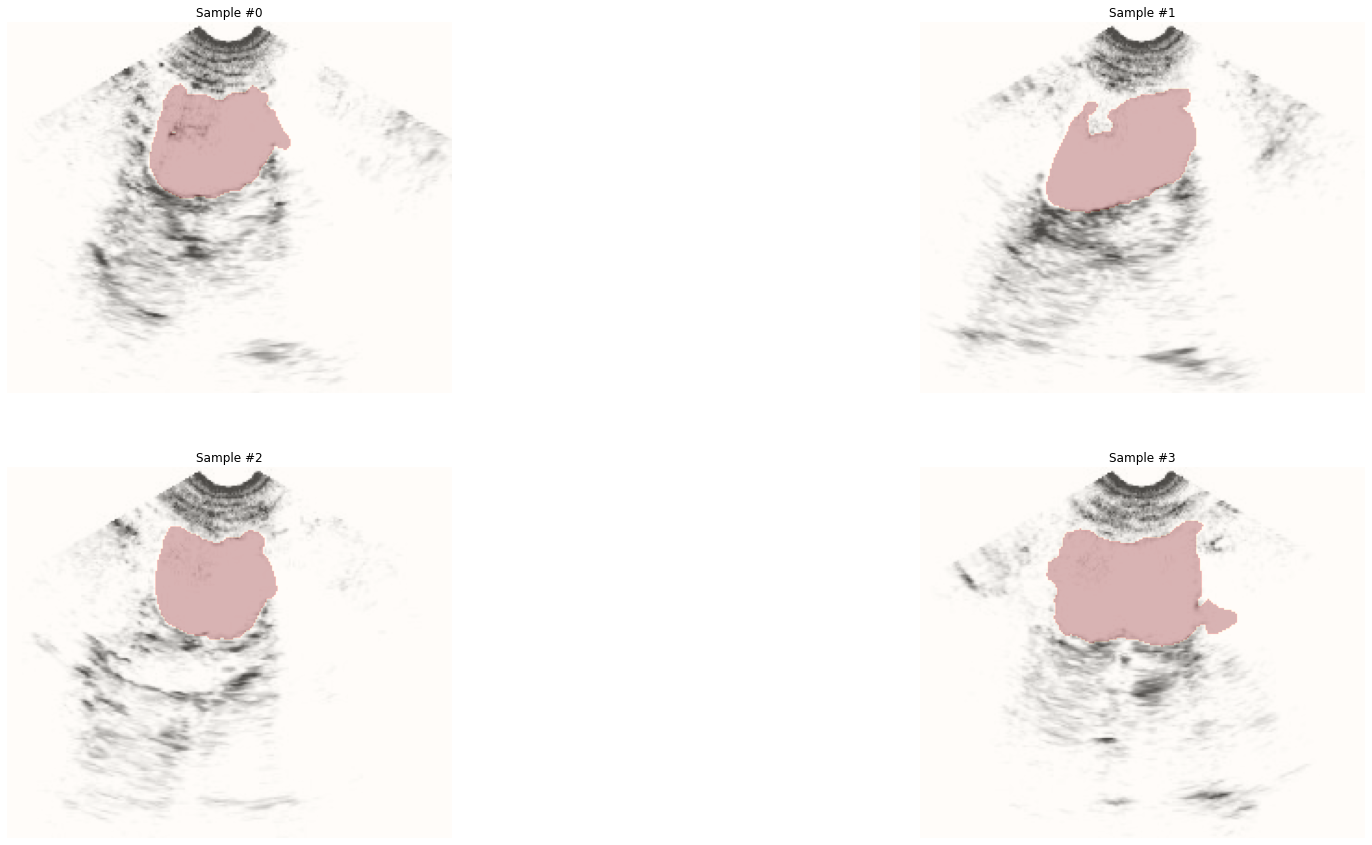

In [39]:
show_sample_test_result(test_dataset, predicted_mask)